In [1]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(lme4))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(variancePartition))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(doParallel))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggplot2))

Warning message:
“package ‘stringr’ was built under R version 4.3.2”


In [2]:
#reading data for baseline and follow-up
data_t1 <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/delta_expression_disease-status-association/input_files/data_t1.txt", header = T, sep = ",")
data_t2 <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/delta_expression_disease-status-association/input_files/data_t2.txt", header = T, sep = ",")

In [3]:
#reading upregulated and downregulated proteins files
up_prot <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/UP_FDR-corrected_with_all_info.txt", header = T, sep = ",")
down_prot <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/DOWN_FDR-corrected_with_all_info.txt", header = T, sep = ",")

In [4]:
# Assume df1 and df2 are for timepoint 1 and 2 respectively
# df3 has protein_ids you want to focus on

# 1. Get list of proteins to subset
proteins_of_interest <- up_prot$OlinkID

# 2. Subset df1 and df2 to include only relevant columns
# Also keep the necessary metadata columns
common_columns <- c("SampleID", "SubjectID", "Age", "Age2", "Gender", 
                    "MeanNPX", "Site", "storage_time", "status", "timepoint")

data_t1 <- as.data.frame(data_t1)
data_t2 <- as.data.frame(data_t2)
df1_sub <- data_t1[, c(common_columns, proteins_of_interest)]
df2_sub <- data_t2[, c(common_columns, proteins_of_interest)]

# 3. Merge data from timepoint 1 and 2 using subjectID
merged_df <- merge(df1_sub, df2_sub, by = "SubjectID", suffixes = c("_T1", "_T2"))

# 4. Compute delta values for proteins: T2 - T1
delta_proteins <- sapply(proteins_of_interest, function(p) {
  merged_df[[paste0(p, "_T2")]] - merged_df[[paste0(p, "_T1")]]
})
colnames(delta_proteins) <- paste0("delta_", proteins_of_interest)

# 5. Create new dataframe with delta values and metadata
final_df <- cbind(
  SubjectID = merged_df$SubjectID,
  SampleID_T1 = merged_df$SampleID_T1,
  SampleID_T2 = merged_df$SampleID_T2,
  status_T1 = merged_df$status_T1,
  status_T2 = merged_df$status_T2,
  Age_T1 = merged_df$Age_T1,
  Age_T2 = merged_df$Age_T2,
  Age_squared = (merged_df$Age_T2 * merged_df$Age_T2),  
  Gender = merged_df$Gender_T1,
  Site = merged_df$Site_T1,
  storage_time_T1 = merged_df$storage_time_T1,
  storage_time_T2 = merged_df$storage_time_T2,
  MeanNPX_T1 = merged_df$MeanNPX_T1,
  MeanNPX_T2 = merged_df$MeanNPX_T2,
  as.data.frame(delta_proteins)
)

# Optional: convert to data.frame if needed
final_df <- as.data.frame(final_df)
final_df <- final_df %>% 
  filter(status_T2 != "healthy")
head(final_df)

,SubjectID,SampleID_T1,SampleID_T2,status_T1,status_T2,Age_T1,Age_T2,Age_squared,Gender,Site,⋯,delta_OID30772,delta_OID30790,delta_OID30865,delta_OID30955,delta_OID31031,delta_OID31137,delta_OID31220,delta_OID31340,delta_OID31342,delta_OID31380
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,392,Sample_80,Sample_312,prediabetes,prediabetes,50,50,2500,w,TUE,⋯,0.4884,0.4841,2.1138,-0.5424,0.7650,0.1497,0.4300,0.2144,0.2098,-1.2914
2,654,Sample_88,Sample_322,prediabetes,prediabetes,59,59,3481,w,TUE,⋯,-0.0433,0.0105,-1.7969,2.7774,-0.7079,-1.6632,0.1528,-0.0757,-0.8147,-0.1623
3,1338,Sample_79,Sample_314,prediabetes,prediabetes,66,66,4356,w,TUE,⋯,-0.0846,0.2747,6.5011,-1.2939,-0.4247,-0.9276,-0.0475,0.8952,-0.2949,0.2921
4,1382,Sample_143,Sample_349,prediabetes,prediabetes,50,50,2500,w,TUE,⋯,-0.0082,-0.1073,2.2344,-1.2415,-0.5081,0.0254,-2.0481,0.6478,0.0820,-0.0838
5,1400,Sample_108,Sample_344,diabetes,diabetes,61,61,3721,m,TUE,⋯,-0.1495,-0.0402,-1.1546,-1.8352,0.8336,1.0835,-0.4876,0.3281,0.2926,0.1131
6,1489,Sample_83,Sample_310,diabetes,diabetes,65,65,4225,m,TUE,⋯,-0.2880,-0.0961,1.5505,-1.3752,-0.3447,-1.3151,-0.0950,-0.4356,-0.2645,-0.1348


In [5]:
# Filter only prediabetes and T2D
final_df_filtered <- final_df[final_df$status_T2 %in% c("prediabetes", "diabetes"), ]

# Ensure status_T2 is a factor
final_df_filtered$status_T2 <- factor(final_df_filtered$status_T2, levels = c("prediabetes", "diabetes"))

# Identify protein columns
protein_cols <- grep("^delta_", names(final_df_filtered), value = TRUE)

# Run linear models for each protein
results <- lapply(protein_cols, function(prot) {
  formula <- as.formula(paste0(prot, " ~ status_T2 + MeanNPX_T1 + storage_time_T1 + MeanNPX_T2 + storage_time_T2 + Age_T2 + Age_squared + Gender + Site"))
  #formula <- as.formula(paste0(prot, " ~ status_T2"))
  model <- lm(formula, data = final_df_filtered)
  pval <- summary(model)$coefficients["status_T2diabetes", "Pr(>|t|)"]
  estimate <- summary(model)$coefficients["status_T2diabetes", "Estimate"]
  # extract 95% CI
  ci <- confint(model, level = 0.95)["status_T2diabetes", ]
  return(data.frame(protein = prot, estimate = estimate, pval = pval, CI_lower = ci[1], CI_upper = ci[2]))
})

# Combine results
results_df <- do.call(rbind, results)

# FDR correction
results_df$fdr <- p.adjust(results_df$pval, method = "fdr")

In [6]:
results <- results_df %>%
  mutate(
    fdr = p.adjust(pval, method = "fdr"),
    neglogFDR = -log10(fdr),
    significant = ifelse(fdr < 0.05, "FDR < 0.05", "NS")
  )

# Filter for significant proteins
sig_results <- results %>%
  filter(fdr < 0.05) %>%
  arrange(estimate)   # order by effect size
sig_results$protein <- sub("^delta_", "", sig_results$protein)
#getting real protein names
sig_results <- sig_results %>%
  left_join(up_prot %>% select(OlinkID, Assay.x),
            by = c("protein" = "OlinkID"))

In [7]:
#identifying novel protein biomarkers compared to previous studies of circulating proteome
plasma_prot <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/literature_review/tmp1.txt", header = F)
serum_prot <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/literature_review/tmp2.txt", header = F)

serum_proteins <- toupper(serum_prot$V1)
plasma_proteins <- toupper(plasma_prot$V1)
# Combine known proteins
known_proteins <- union(serum_proteins, plasma_proteins)

delta_proteins <- toupper(sig_results$Assay.x)
# Find unique novel proteins using setdiff
unique_delta <- setdiff(delta_proteins, known_proteins)

# Print the number of novel proteins
cat("Novel proteins:", length(unique_delta))
cat("\n")
unique_delta

Novel proteins: 11


[1] "NHLRC3" "CNTN3"  "NT5E"   "MAN2B2" "GGT1"   "CEMIP2" "MME"    "MUC13" 
 [9] "ECHDC3" "IGSF9"  "MAMDC4"

In [8]:
# Create a new column to indicate which proteins should be highlighted
sig_results$highlight <- sig_results$Assay.x %in% unique_delta

# Create a new color palette
# You can customize these colors. Here, "red" is for novel proteins and "gray" is for others.
colors <- c("TRUE" = "red", "FALSE" = "dark blue")
sig_results <- sig_results %>%
  mutate(highlight = ifelse(highlight, "Novel", "Known"))

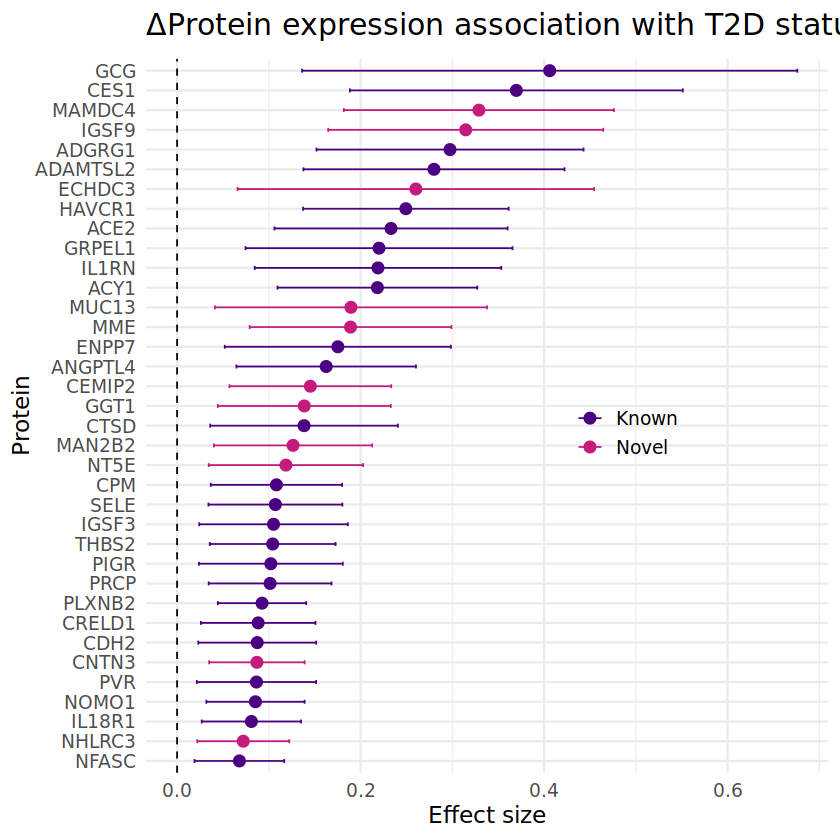

In [23]:
p <- ggplot(sig_results, aes(
    x = estimate,
    y = reorder(Assay.x, estimate),
    color = highlight
  )) +
  geom_point(size = 3) +
  geom_errorbarh(aes(xmin = CI_lower, xmax = CI_upper), height = 0.2) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  theme_minimal(base_size = 14) +
  labs(
    title = expression(Delta*"Protein expression association with T2D status at follow-up"),
    x = "Effect size",
    y = "Protein",
    color = ""
  ) +
  theme(
    plot.title = element_text(size = 18),
    legend.position = c(0.70, 0.5)
  ) + 
  scale_color_manual(
    values = c(
      "Novel" = "#C51B7D",   # purple-pink
      "Known" = "#4B0082"    # sky blue
    )
  )



print(p)
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/delta_expression_disease-status-association/plots/delta-expression_association_with_T2D-status_forest_plot.pdf", plot = p, width = 12, height = 7)